# Processing Example: Musgraves Dataset

Steps:

0. [X] Import packages, set paths, check versions, configure variables
1. [ ] Review the dataset and folder
2. [ ] Select a test station
   - Will use SA300 with SA275 as remote reference (because this station is in the mtpy notebook)
5. [ ] Plot a reference transfer function
6. [ ] Take a look at the time series
7. [ ] Process with aurora (SS)
8. [ ] Process with aurora RR
9. [ ] Compare Transfer Functions
10. [ ] Run on HPC 

## 0. Import packages

In [1]:
import aurora
import mt_metadata
import mth5
import pandas as pd
import pathlib
import socket
import warnings

from aurora.config.config_creator import ConfigCreator
from aurora.config import BANDS_TEST_FAST_FILE
from aurora.general_helper_functions import BAND_SETUP_PATH
from aurora.pipelines.process_mth5 import process_mth5
from aurora.pipelines.run_summary import RunSummary
from aurora.transfer_function.kernel_dataset import KernelDataset
from mth5.mth5 import MTH5
from mt_metadata.transfer_functions.processing.aurora.channel_nomenclature import CHANNEL_MAPS

warnings.filterwarnings('ignore')

In [2]:
from IPython.display import HTML, display

def set_background(color):    
    script = (
        "var cell = this.closest('.jp-CodeCell');"
        "var editor = cell.querySelector('.jp-Editor');"
        "editor.style.background='{}';"
        "this.parentNode.removeChild(this)"
    ).format(color)
    
    display(HTML('<img src onerror="{}" style="display:none">'.format(script)))
set_background("orange")

### Check versions

In [3]:
print(f"aurora.__version__ {aurora.__version__}")
print(f"mt_metadata.__version__ {mt_metadata.__version__}")
print(f"mth5.__version__ {mth5.__version__}")

aurora.__version__ 0.3.11
mt_metadata.__version__ 0.3.3
mth5.__version__ 0.4.1


### Set some Paths
- this is a little overdone

In [4]:
hostname = socket.gethostname()
print(f"hostname: {hostname}")
if "gadi" in hostname:
    my80_path = pathlib.Path("/g/data/my80")
elif hostname == "namazu":
    my80_path = pathlib.Path("/home/kkappler/data/gadi/g/data/my80")
    
au_scope_mt_collection_path = my80_path.joinpath("AuScope_MT_collection")
auslamp_path = au_scope_mt_collection_path.joinpath("AuScope_AusLAMP")
musgraves_path = auslamp_path.joinpath("Musgraves_APY")
data_dir = musgraves_path
assert data_dir.exists()
#data_dir = pathlib.Path("/home/kkappler/data/gadi/g/data/my80/AuScope_MT_collection/AuScope_AusLAMP/Musgraves_APY")

hostname: namazu


## 1. Existing Directory Structure:

The Musgraves dataset is organized by Territory (NT, SA, WA), and within each territory there are levels 0, 1, and 2. 

Use NT as an example to look at the level structure:

There are two folders of interest for this exercise, the MTH5 ones:
- level_0/Concatenated_Time_Series_MTH5_per_run
- level_1/Concatenated_Resampled_Rotated_Time_Series_MTH5

We will abbreviate these as level 0 and 1 for indexing the hdf5s.

In [5]:
def get_musgraves_availability_df(data_dir):
    """
    recusively search for h5 files in data_dir, tabulate and return a dataframe
    """
    all_mth5_files = list(data_dir.rglob("*h5"))
    num_mth5 = len(all_mth5_files)
    print(f"Found {num_mth5} h5 files")
    levels = num_mth5 * [""]
    station_ids = num_mth5 * [""]
    territories = num_mth5 * [""]
    paths = num_mth5 * [""]

    for i_filepath, filepath in enumerate(all_mth5_files):
        levels[i_filepath] = str(filepath).split("level_")[1][0]
        station_ids[i_filepath] = filepath.stem
        territories[i_filepath] = str(filepath).split("Musgraves_APY/")[1][0:2]
        paths[i_filepath] = filepath
    df_dict = {"level": levels, "territory": territories, "station_id": station_ids, "path": paths}
    df = pd.DataFrame(data=df_dict)

    return df

In [108]:
availability_df = get_musgraves_availability_df(data_dir)
availability_df

Found 6 h5 files


,level,territory,station_id,path
0,1,NT,WANT38,/home/kkappler/data/gadi/g/data/my80/AuScope_M...
1,1,NT,SA349,/home/kkappler/data/gadi/g/data/my80/AuScope_M...
2,1,SA,SA225-2,/home/kkappler/data/gadi/g/data/my80/AuScope_M...
3,1,SA,SA275,/home/kkappler/data/gadi/g/data/my80/AuScope_M...
4,1,SA,SA300,/home/kkappler/data/gadi/g/data/my80/AuScope_M...
5,1,SA,SA227,/home/kkappler/data/gadi/g/data/my80/AuScope_M...


### Use pathlinb to index the hd5 files


In [76]:
all_mth5_files = data_dir.rglob("*h5")
all_mth5_files_list = list(all_mth5_files)

In [77]:
num_mth5 = len(all_mth5_files_list)
print(f"Found {num_mth5} h5 files")
# print(list(all_mth5_files))

Found 6 h5 files


### Make a table of these files, extracting reference properties: "level", "territory", "station_id"

In [78]:
levels = num_mth5 * [""]
station_ids = num_mth5 * [""]
territories = num_mth5 * [""]
paths = num_mth5 * [""]

for i_filepath, filepath in enumerate(all_mth5_files_list):
    levels[i_filepath] = str(filepath).split("level_")[1][0]
    station_ids[i_filepath] = filepath.stem
    territories[i_filepath] = str(filepath).split("Musgraves_APY/")[1][0:2]
    paths[i_filepath] = filepath

In [79]:
df_dict = {"level":levels, "territory":territories, "station_id": station_ids, "path":paths}
df = pd.DataFrame(data=df_dict)
df

,level,territory,station_id,path
0,1,NT,WANT38,/home/kkappler/data/gadi/g/data/my80/AuScope_M...
1,1,NT,SA349,/home/kkappler/data/gadi/g/data/my80/AuScope_M...
2,1,SA,SA225-2,/home/kkappler/data/gadi/g/data/my80/AuScope_M...
3,1,SA,SA275,/home/kkappler/data/gadi/g/data/my80/AuScope_M...
4,1,SA,SA300,/home/kkappler/data/gadi/g/data/my80/AuScope_M...
5,1,SA,SA227,/home/kkappler/data/gadi/g/data/my80/AuScope_M...


### Take a look at the distribution of the data

In [80]:
df[["level", "territory",]].value_counts()

level  territory
1      SA           4
       NT           2
Name: count, dtype: int64

### Northern Territory (NT) has only two stations so we can use it for some testing

In [81]:
nt_df = df[(df.territory=="NT") & (df.level=="1")]
nt_df

,level,territory,station_id,path
0,1,NT,WANT38,/home/kkappler/data/gadi/g/data/my80/AuScope_M...
1,1,NT,SA349,/home/kkappler/data/gadi/g/data/my80/AuScope_M...


### Open the mth5 files using a dict for tracking who's who

In [82]:
mth5_objs = {x:MTH5() for x in nt_df.station_id}


In [83]:
for i, row in nt_df.iterrows():
    mth5_objs[row.station_id].open_mth5(row.path, "r")

### Take a gander at the structure

In [84]:
mth5_objs["SA349"]

/:
    |- Group: Experiment
    --------------------
        |- Group: Reports
        -----------------
        |- Group: Standards
        -------------------
            --> Dataset: summary
            ......................
        |- Group: Surveys
        -----------------
            |- Group: AusLAMP_Musgraves
            ---------------------------
                |- Group: Filters
                -----------------
                    |- Group: coefficient
                    ---------------------
                        |- Group: bz_adjustment
                        -----------------------
                        |- Group: gain_b
                        ----------------
                        |- Group: gain_e
                        ----------------
                        |- Group: gain_eonly
                        --------------------
                    |- Group: fap
                    -------------
                    |- Group: fir
                    -------------
 

### Looks like just one run here

In [85]:
mth5_objs["WANT38"]

/:
    |- Group: Experiment
    --------------------
        |- Group: Reports
        -----------------
        |- Group: Standards
        -------------------
            --> Dataset: summary
            ......................
        |- Group: Surveys
        -----------------
            |- Group: AusLAMP_Musgraves
            ---------------------------
                |- Group: Filters
                -----------------
                    |- Group: coefficient
                    ---------------------
                        |- Group: bz_adjustment
                        -----------------------
                        |- Group: gain_b
                        ----------------
                        |- Group: gain_e
                        ----------------
                        |- Group: gain_eonly
                        --------------------
                    |- Group: fap
                    -------------
                    |- Group: fir
                    -------------
 

In [86]:
channel_summaries = {}
for station_id, mth5_obj in mth5_objs.items():
    channel_summary_df = mth5_obj.channel_summary.to_dataframe()
    channel_summaries[station_id] = channel_summary_df

In [87]:
channel_summaries["SA349"]

,survey,station,run,latitude,longitude,elevation,component,start,end,n_samples,sample_rate,measurement_type,azimuth,tilt,units,hdf5_reference,run_hdf5_reference,station_hdf5_reference
0,none,SA349,1,-25.99472,130.49991,646.0,bx,2017-08-20 00:00:00+00:00,2017-10-18 23:59:59.999999+00:00,5184000,1.0,magnetic,0.0,0.0,nT,<HDF5 object reference>,<HDF5 object reference>,<HDF5 object reference>
1,none,SA349,1,-25.99472,130.49991,646.0,by,2017-08-20 00:00:00+00:00,2017-10-18 23:59:59.999999+00:00,5184000,1.0,magnetic,90.0,0.0,nT,<HDF5 object reference>,<HDF5 object reference>,<HDF5 object reference>
2,none,SA349,1,-25.99472,130.49991,646.0,bz,2017-08-20 00:00:00+00:00,2017-10-18 23:59:59.999999+00:00,5184000,1.0,magnetic,0.0,0.0,nT,<HDF5 object reference>,<HDF5 object reference>,<HDF5 object reference>
3,none,SA349,1,-25.99472,130.49991,646.0,ex,2017-08-20 00:00:00+00:00,2017-10-18 23:59:59.999999+00:00,5184000,1.0,electric,0.0,0.0,mV/m,<HDF5 object reference>,<HDF5 object reference>,<HDF5 object reference>
4,none,SA349,1,-25.99472,130.49991,646.0,ey,2017-08-20 00:00:00+00:00,2017-10-18 23:59:59.999999+00:00,5184000,1.0,electric,90.0,0.0,mV/m,<HDF5 object reference>,<HDF5 object reference>,<HDF5 object reference>


In [88]:
channel_summaries["WANT38"]

,survey,station,run,latitude,longitude,elevation,component,start,end,n_samples,sample_rate,measurement_type,azimuth,tilt,units,hdf5_reference,run_hdf5_reference,station_hdf5_reference
0,none,WANT38,1,-25.00617,129.00358,731.0,bx,2016-10-25 00:00:00+00:00,2016-11-14 23:59:59.999999+00:00,1814400,1.0,magnetic,0.0,0.0,nT,<HDF5 object reference>,<HDF5 object reference>,<HDF5 object reference>
1,none,WANT38,1,-25.00617,129.00358,731.0,by,2016-10-25 00:00:00+00:00,2016-11-14 23:59:59.999999+00:00,1814400,1.0,magnetic,90.0,0.0,nT,<HDF5 object reference>,<HDF5 object reference>,<HDF5 object reference>
2,none,WANT38,1,-25.00617,129.00358,731.0,bz,2016-10-25 00:00:00+00:00,2016-11-14 23:59:59.999999+00:00,1814400,1.0,magnetic,0.0,0.0,nT,<HDF5 object reference>,<HDF5 object reference>,<HDF5 object reference>
3,none,WANT38,1,-25.00617,129.00358,731.0,ex,2016-10-25 00:00:00+00:00,2016-11-14 23:59:59.999999+00:00,1814400,1.0,electric,0.0,0.0,mV/m,<HDF5 object reference>,<HDF5 object reference>,<HDF5 object reference>
4,none,WANT38,1,-25.00617,129.00358,731.0,ey,2016-10-25 00:00:00+00:00,2016-11-14 23:59:59.999999+00:00,1814400,1.0,electric,90.0,0.0,mV/m,<HDF5 object reference>,<HDF5 object reference>,<HDF5 object reference>


We can see that SA349 is from 2017, and WANT38 is from 2016, so we cannot do RR processing here.

In [95]:
mth5_objs.keys()

dict_keys(['WANT38', 'SA349'])

In [100]:
for i,row in nt_df.iterrows():
    station_obj = mth5_objs[row.station_id].get_station(row.station_id, survey="AusLAMP_Musgraves")
    print(i,station_obj)

0 /Experiment/Surveys/AusLAMP_Musgraves/Stations/WANT38:
    |- Group: 001
    -------------
        --> Dataset: bx
        .................
        --> Dataset: by
        .................
        --> Dataset: bz
        .................
        --> Dataset: ex
        .................
        --> Dataset: ey
        .................
    |- Group: Transfer_Functions
    ----------------------------
1 /Experiment/Surveys/AusLAMP_Musgraves/Stations/SA349:
    |- Group: 001
    -------------
        --> Dataset: bx
        .................
        --> Dataset: by
        .................
        --> Dataset: bz
        .................
        --> Dataset: ex
        .................
        --> Dataset: ey
        .................
    |- Group: Transfer_Functions
    ----------------------------


### Close the mth5s

In [101]:
for station_id, mth5_obj in mth5_objs.items():
    print(f"MTH5 file version is {mth5_obj._MTH5__file_version}") 
    mth5_obj.close_mth5()

MTH5 file version is 0.2.0
23:11:11T14:21:41 | INFO | line:760 |mth5.mth5 | close_mth5 | Flushing and closing /home/kkappler/data/gadi/g/data/my80/AuScope_MT_collection/AuScope_AusLAMP/Musgraves_APY/NT/level_1/Concatenated_Resampled_Rotated_Time_Series_MTH5/WANT38.h5
MTH5 file version is 0.2.0
23:11:11T14:21:41 | INFO | line:760 |mth5.mth5 | close_mth5 | Flushing and closing /home/kkappler/data/gadi/g/data/my80/AuScope_MT_collection/AuScope_AusLAMP/Musgraves_APY/NT/level_1/Concatenated_Resampled_Rotated_Time_Series_MTH5/SA349.h5


## 2. Select a test station

Station SA300 is referenced in the mtpy exmaple notebook so let's use it.  Based on a list of station combinations provided by Nigel, we will use SA275 as the reference station.

In [8]:
station_combinations = [('SA225-2','SA294','001','001'),
                        ('SA227','SA243','001','001'),
                        #('SA242','SA242','001','001'),  ### SA242 uses WAS352 as RR - we don't have this station
                        ('SA243','SA294','001','001'),
                        ('SA245','SA245','001','001'),
                        ('SA246','SA294','001','001'),  ### SA246 has multiple runs
                        ('SA247','SA294','001','001'),
                        ('SA248','SA275','001','001'),
                        ('SA249','SA275','001','001'),
                        ('SA250','SA275','001','001'),
                        ('SA251','SA275','001','001'),
                        ('SA252','SA275','001','001'),
                        ('SA26W-2','SA275','001','001'),
                        ('SA270','SA294','001','001'),
                        ('SA271','SA294','001','001'),  ### original script uses SA294 for local and remote?
                        ('SA272','SA294','001','001'),
                        ('SA273','SA275','001','001'),  ### original uses SA273 ex,ey,bz SA251 bx,by SA275 RR
                        ('SA274-2','SA294','001','001'), ### SA274 not used
                        ('SA275','SA252','001','001'),
                        ('SA276','SA275','001','001'),
                        ('SA277','SA275','001','001'),
                        ('SA293-2','SA294','001','001'),
                        ('SA294','SA295','001','001'),
                        ('SA295','SA294','001','001'),
                        ('SA296','SA294','001','001'),
                        ('SA297','SA294','001','001'),
                        ('SA298','SA294','001','001'),
                        # ('SA299','SA275','004','001'),  ### SA299 has multiple runs
                        ('SA300','SA275','001','001'),
                        ('SA301','SA275','001','001'),  ### SA271 doesn't overlap - tried SA275 and it worked
                        ('SA319','SA294','001','001'),
                        #('SA320-2','SA320-2','001','001'), ### SA320-2 and SA294 don't have enough overlap
                        ('SA321','SA294','001','001'),
                        ('SA322','SA275','001','001'),
                        ('SA323','SA275','001','001'),
                        ('SA324-2','SA294','001','001'), ### SA324-2 has multiple runs
                        ('SA325-2','SA294','001','001'),
                        ('SA326N','SA275','001','001'),
                        ('SA326S','SA275','001','001'),
                        #('SA344-2','SA344-2','001','001'), ### length of time series section not long enough
                        ('SA345','SA295','001','001'),
                        ('SA346','SA294','001','001'),
                        ('SA347','SA275','001','001'),
                        ('SA348','SA275','001','001'),
                        # ('SA349','SA275','001','001'), # SA349 is grouped under NT
                        ('SA350','SA275','001','001'),
                        ('SA351','SA275','001','001'),
                        ('WA10','WA30','001','001'),
                        ('WA13','WA30','001','001'),
                        ('WA14','WA30','001','001'),
                        ('WA15','WA30','001','001'),
                        ('WA26','WA30','001','001'),
                        ('WA27','WA30','001','001'),
                        ('WA29','WA30','001','001'),
                        ('WA30','WA45','001','001'),
                        ('WA31','WA30','001','001'),
                        ('WA42','WA30','001','001'),
                        #('WA43','WA43','001','001'),  ### original uses SA075 as both local and remote??
                        ('WA44','WA30','001','001'),
                        ('WA45','WA46','001','001'),
                        ('WA46','WA45','001','001'),
                        ('WA47','WA30','001','001'),
                        ('WA54','WA61','001','001'),
                        ('WA55','WA61','001','001'),
                        ('WA56','WA61','001','001'),  ### original uses WA56 and WA30 which don't overlap
                        ('WA57','WA58','001','001'),
                        ('WA58','WA57','001','001'),
                        ('WA60','WA61','001','001'),
                        ('WA61','WA71','001','001'),
                        ('WA62','WA57','001','001'),
                        ('WA63','WA57','001','001'),
                        ('WA64','WA57','001','001'),
                        ('WA65','WA57','001','001'),
                        ('WA66','WA61','001','001'),
                        ('WA67','WA61','001','001'),
                        ('WA68','WA57','001','001'),
                        ('WA69','WA61','001','001'),
                        ('WA70','WA61','001','001'),  ### original uses WA70 ex,ey,bz, WA69 bx,by, WA61 bx,by
                        ('WA71','WA61','001','001'),
                        ('WA72','WA61','001','001'),
                        ('WA73','WA57','001','001'),
                        ('WA74','WA57','001','001'),
                        ('WA75','WA57','001','001'),
                        ('WANT19','WA30','001','001'),
                        ('WANT38','WANT38','001','001'),
                        ('WANT45','WA30','001','001'),
                        ('WASA302','WA30','001','001'),
                        ('WASA327','WA30','001','001')]

### Try processing stations individually: 

## Define the station, and remmote reference if used

In [68]:
station_id = "SA300"
reference_station_id = "SA275"
row = df[df.station_id==station_id].iloc[0]
reference_row = df[df.station_id==reference_station_id].iloc[0]
print(row)
print(reference_row)
RR = True

level                                                         1
territory                                                    SA
station_id                                                SA300
path          /home/kkappler/data/gadi/g/data/my80/AuScope_M...
Name: 4, dtype: object
level                                                         1
territory                                                    SA
station_id                                                SA275
path          /home/kkappler/data/gadi/g/data/my80/AuScope_M...
Name: 3, dtype: object


## 3. Take a look at the TFs
<div class="alert alert-block alert-danger">
<b>TODO:</b> Add method to read the EDI for 300a.
</div>

TypeError: 'NoneType' object is not subscriptable

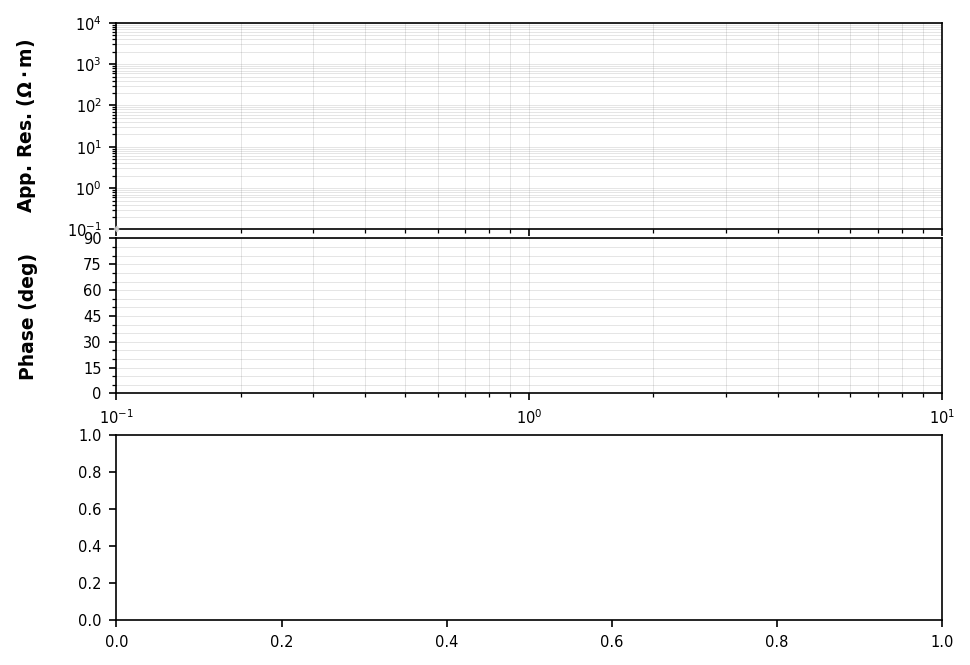

In [53]:
from mtpy import MT
edi_path = "/home/kkappler/data/gadi/g/data/my80/AuScope_MT_collection/AuScope_AusLAMP/Musgraves_APY/NT/level_2/EDI/GSSA/SA349.edi"
mt_obj = MT(edi_path)
mt_obj.plot_mt_response()

## 4. Take a look at the Time Series

<div class="alert alert-block alert-danger">
<b>TODO:</b> Add Some Time Series Plots
</div>

## 5 & 6. Processing

## Define the Transfer Function Kernel Dataset

In [69]:
if RR:
    mth5_files = [row.path, reference_row.path]
else:
    mth5_files = [row.path, ]
    reference_station_id = None

mth5_run_summary = RunSummary()
mth5_run_summary.from_mth5s(mth5_files)
run_summary = mth5_run_summary.clone()
#run_summary.check_runs_are_valid(drop=True)
kernel_dataset = KernelDataset()
if RR:
    kernel_dataset.from_run_summary(run_summary, row.station_id, reference_station_id)
else:
    kernel_dataset.from_run_summary(run_summary, row.station_id, None)

# Add survey and run ID -- this is a workaround for antique mth5 files
kernel_dataset.df["survey"] = "AusLAMP_Musgraves"
kernel_dataset.df["run_id"] = "001"


kernel_dataset.df
# kernel_dataset.drop_runs_shorter_than(5000)
# if len(kernel_dataset.df) == 0:
#     print("No RR Coverage, casting to single station processing")
#     kernel_dataset.from_run_summary(run_summary, row.station_id)

23:11:11T14:14:52 | INFO | line:760 |mth5.mth5 | close_mth5 | Flushing and closing /home/kkappler/data/gadi/g/data/my80/AuScope_MT_collection/AuScope_AusLAMP/Musgraves_APY/SA/level_1/Concatenated_Resampled_Rotated_Time_Series_MTH5/SA300.h5
23:11:11T14:14:53 | INFO | line:760 |mth5.mth5 | close_mth5 | Flushing and closing /home/kkappler/data/gadi/g/data/my80/AuScope_MT_collection/AuScope_AusLAMP/Musgraves_APY/SA/level_1/Concatenated_Resampled_Rotated_Time_Series_MTH5/SA275.h5


,survey,station_id,run_id,start,end,sample_rate,input_channels,output_channels,channel_scale_factors,valid,mth5_path,remote,duration,fc
0,AusLAMP_Musgraves,SA300,001,2017-08-19 00:00:00+00:00,2017-08-23 23:59:59.999999+00:00,1.0,"[bx, by]","[bz, ex, ey]","{'bx': 1.0, 'by': 1.0, 'bz': 1.0, 'ex': 1.0, '...",True,/home/kkappler/data/gadi/g/data/my80/AuScope_M...,False,431999.999999,False
1,AusLAMP_Musgraves,SA275,001,2017-08-19 00:00:00+00:00,2017-08-23 23:59:59.999999+00:00,1.0,"[bx, by]","[bz, ex, ey]","{'bx': 1.0, 'by': 1.0, 'bz': 1.0, 'ex': 1.0, '...",True,/home/kkappler/data/gadi/g/data/my80/AuScope_M...,True,431999.999999,False


## Define the Processing Configuration

In [70]:
cc = ConfigCreator()
config = cc.create_from_kernel_dataset(kernel_dataset,
                                       emtf_band_file=BAND_SETUP_PATH.joinpath("bs_six_level.cfg"))#BANDS_TEST_FAST_FILE)
config.channel_nomenclature.keyword = "musgraves"
config.set_default_input_output_channels()
config.set_default_reference_channels()

## Process the data

In [73]:
show_plot = False
RESULTS_PATH = pathlib.Path().home().joinpath("aurora_test_folder")
xml_file_path = RESULTS_PATH.joinpath(f"{row.station_id}.xml")
z_file = str(xml_file_path).replace("xml", "zss")
tf_cls = process_mth5(config,
                      kernel_dataset,
                      units="MT",
                      show_plot=show_plot,
                      z_file_path=z_file,
                      )
tf_cls.write(fn=xml_file_path, file_type="emtfxml")

23:11:11T14:15:40 | INFO | line:281 |aurora.pipelines.transfer_function_kernel | show_processing_summary | Processing Summary Dataframe:
               survey station_id run_id  valid  remote       duration     fc                                     mth5_obj  stft            run_reference dec_level  dec_factor  sample_rate  window_duration  num_samples_window  num_samples  num_stft_windows
0   AusLAMP_Musgraves      SA275    001   True    True  431999.999999  False  HDF5 file is closed and cannot be accessed.  None  <HDF5 object reference>         0         1.0     1.000000            128.0                 128     431999.0            4499.0
1   AusLAMP_Musgraves      SA275    001   True    True  431999.999999  False  HDF5 file is closed and cannot be accessed.  None  <HDF5 object reference>         1         4.0     0.250000            512.0                 128     107999.0            1124.0
2   AusLAMP_Musgraves      SA275    001   True    True  431999.999999  False  HDF5 file is clos

EMTFXML(station='SA300', latitude=-26.95, longitude=129.93, elevation=563.00)

scale_factor1: 1.0


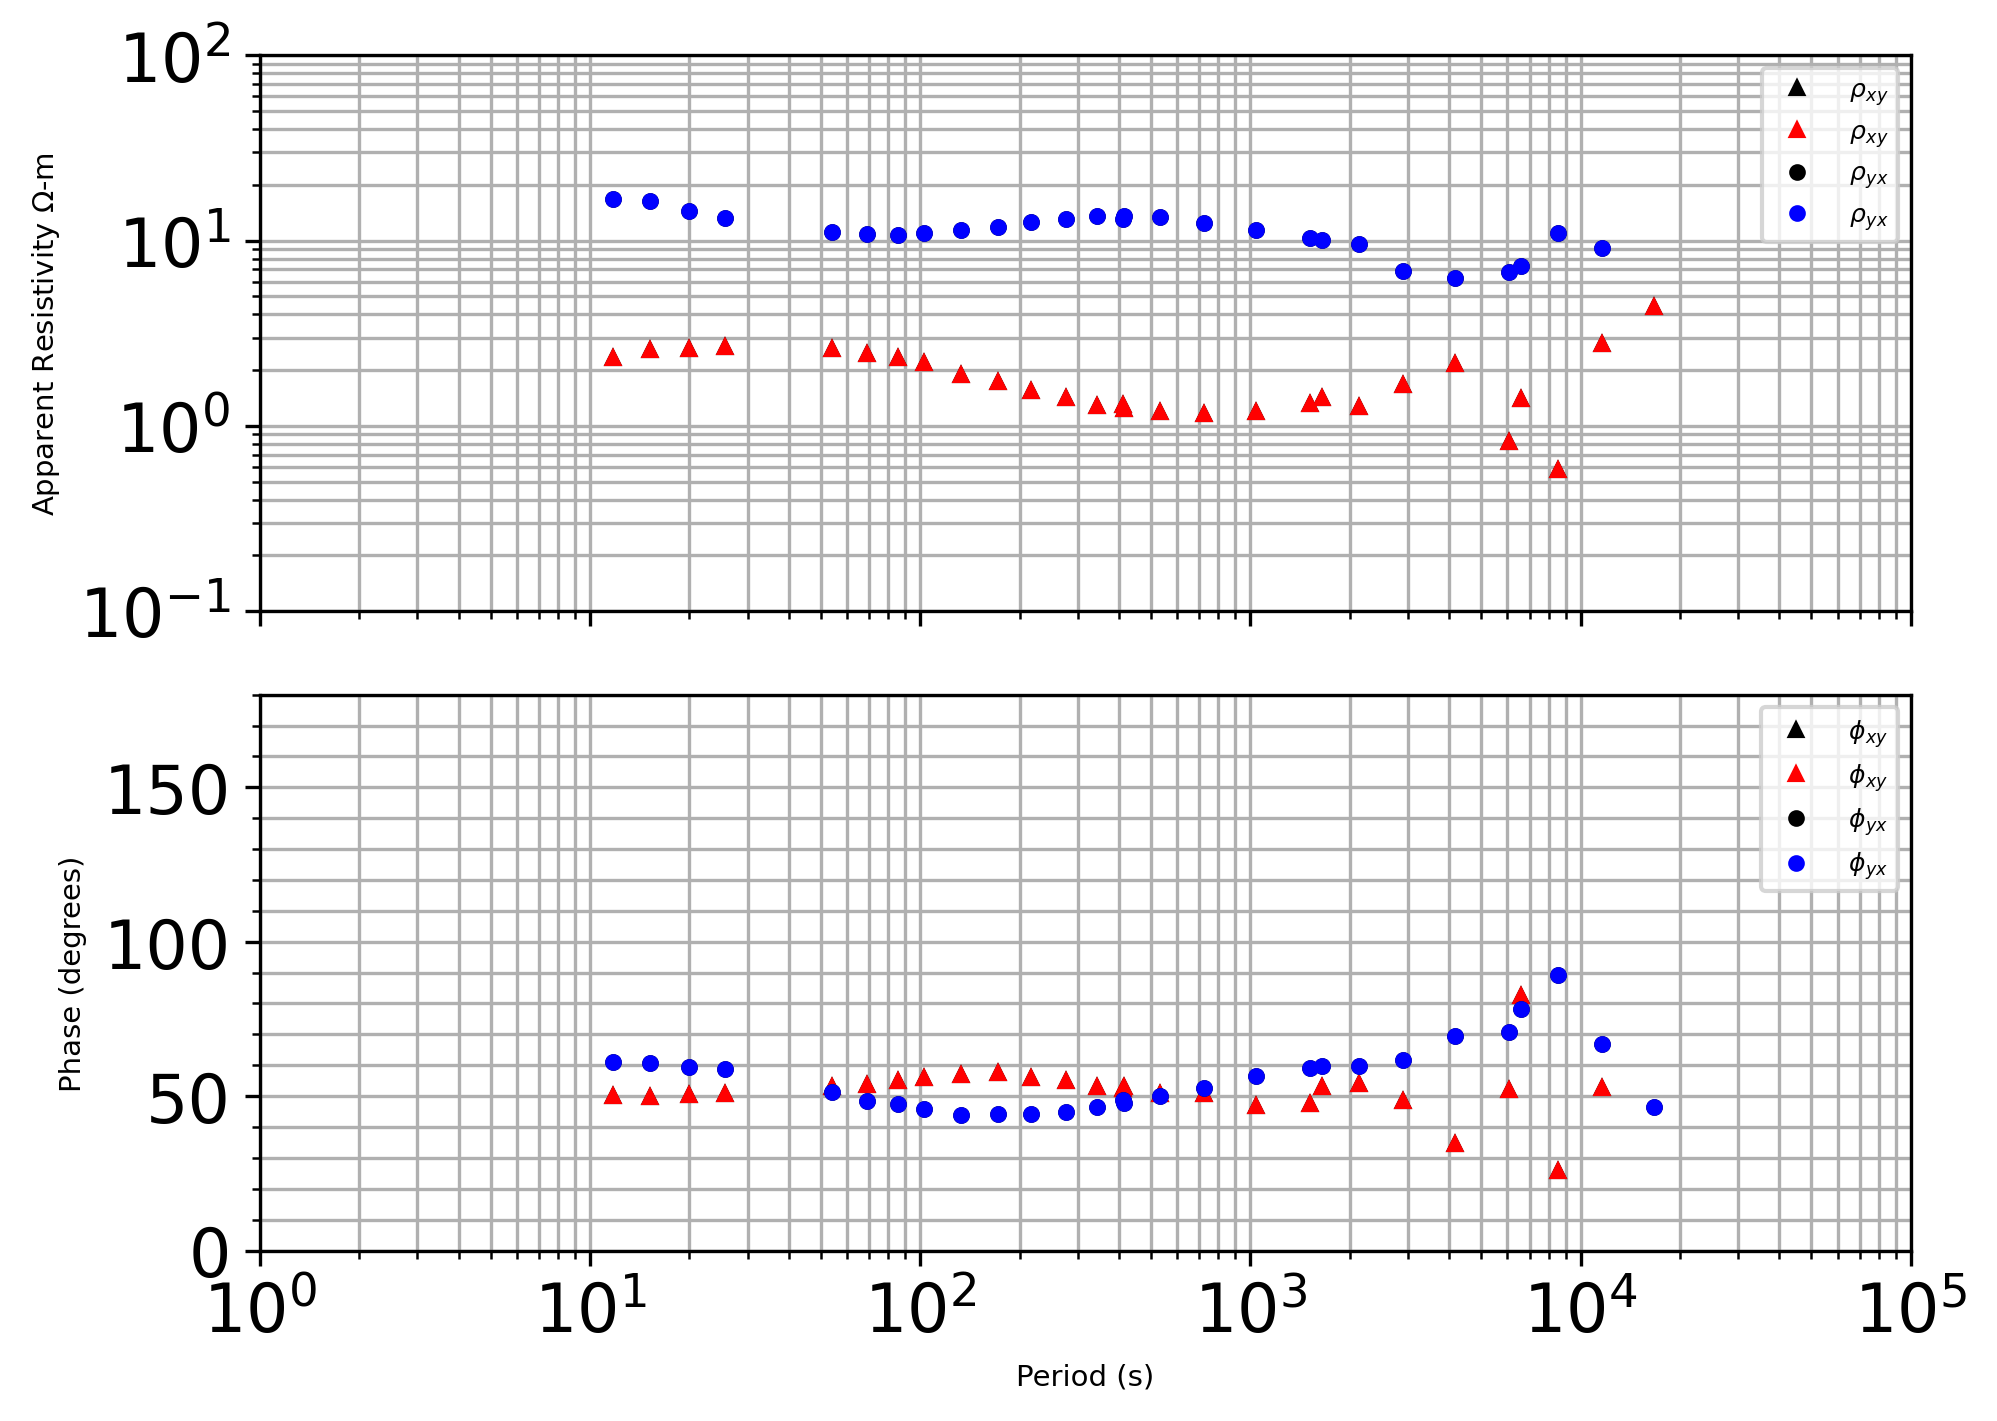

In [74]:
from aurora.transfer_function.plot.comparison_plots import compare_two_z_files
compare_two_z_files(z_file, z_file, xlims=[1e0, 1e5], rho_ylims=[1e-1, 1e2],phi_ylims=[0,180])


In [39]:
tf_cls.transfer_function

<xarray.DataArray 'transfer_function' (period: 8, output: 3, input: 2)>
array([[[ 0.0548111 -2.54529230e-02j, -0.02539603+1.27285145e-02j],
        [-0.23757882-3.04502802e-02j,  0.18747194-6.92981162e-04j],
        [ 0.06278966+2.69536803e-03j, -0.02885283+4.04117742e-04j]],

       [[ 0.03573193-1.89157076e-02j, -0.04121115+4.45920132e-03j],
        [-0.2526236 +2.54708510e-02j,  0.17998257+2.79365006e-02j],
        [ 0.04201114+4.33299079e-03j, -0.02249763-1.02635392e-02j]],

       [[-0.23934745-2.39698530e-02j,  0.09158005-3.90182562e-02j],
        [-0.28832252-7.52853607e-02j,  0.24652862+2.28868212e-02j],
        [ 0.06046929+2.00326358e-02j,  0.01446131-9.73629109e-03j]],

       [[-0.19510192-4.00528976e-02j,  0.13736071+4.97619815e-03j],
        [-0.27405269-7.89084654e-02j,  0.05439342+2.71299037e-02j],
        [ 0.02942827+2.33150806e-02j, -0.00865948+1.03863012e-02j]],

       [[-0.18407413-8.38374391e-02j,  0.10103254+1.15355090e-01j],
        [-0.135011  -1.14151380e-01j,  0.17932726+2.19332686e-02j],
        [ 0.05220633+2.96095836e-02j,  0.00227814+5.09786579e-02j]],

       [[-0.24805412-1.22770813e-01j,  0.02516211+2.55072776e-02j],
        [-0.05144017-4.81603816e-03j,  0.12387603+7.17772452e-03j],
        [-0.00172252-2.26676983e-03j,  0.01313187+3.11525201e-02j]],

       [[-0.19721129+1.87146739e-01j,  0.08280607-1.72067179e-01j],
        [-0.76792214+4.34449946e-01j,  0.64304441-1.25025328e-01j],
        [ 0.14560218+1.22614538e-01j, -0.06786136-2.57526477e-01j]],

       [[-0.09315399+1.92664921e-01j, -0.08734308-5.51047673e-02j],
        [-0.18347275+9.59353025e-02j,  0.20784109-1.03166691e-01j],
        [ 0.24832105+1.06177922e-01j, -0.15109286-2.13827120e-01j]]])
Coordinates:
  * period   (period) float64 19.93 25.73 85.63 ... 411.7 1.042e+03 1.515e+03
  * output   (output) <U2 'ex' 'ey' 'bz'
  * input    (input) <U2 'bx' 'by'
Attributes: (12/14)
    survey:             0
    project:            AusLAMP
    id:                 WANT38
    name:               Dean Range
    latitude:           -25.00617
    longitude:          129.00358
    ...                 ...
    datum:              None
    acquired_by:        Bruce Goleby
    start:              2016-10-24T03:00:00+00:00
    end:                2016-11-15T02:02:00+00:00
    runs_processed:     ['1']
    coordinate_system:  geomagnetic

## 7. Compare Results

<div class="alert alert-block alert-danger">
<b>TODO:</b> Add Comparison.
</div>

## 8. HPC

There are many ways to parallelize.  Here is one example that uses a very simple model and leverages the embarassignly parallelizable nature of processing
many stations.

In this case we will use "pandarallel" to loop over the available stations

In [10]:
availability_df = get_musgraves_availability_df(data_dir)
RESULTS_PATH = pathlib.Path().home().joinpath("aurora_test_folder")

Found 6 h5 files


In [11]:
def enrich_row_with_processing(row):
    mth5_files = [row.path,]
    print("path", row.path, "type", type(row.path))
    my_h5 = pathlib.Path(row.path)
    print(f"{my_h5.exists()} my_h5.exists()")
    xml_file_path = RESULTS_PATH.joinpath(f"{row.station_id}.xml")
    print(xml_file_path)
    
    try:
        mth5_run_summary = RunSummary()
        mth5_run_summary.from_mth5s(mth5_files)
        run_summary = mth5_run_summary.clone()
        #run_summary.check_runs_are_valid(drop=True)
        kernel_dataset = KernelDataset()
        kernel_dataset.from_run_summary(run_summary, row.station_id, None)
    
        # Antique mth5 workaround
        kernel_dataset.df["survey"] = "AusLAMP_Musgraves"
        kernel_dataset.df["run_id"] = "001"
        #print(kernel_dataset.df)
        
        # kernel_dataset.drop_runs_shorter_than(5000)
        # if len(kernel_dataset.df) == 0:
        #     print("No RR Coverage, casting to single station processing")
        #     kernel_dataset.from_run_summary(run_summary, row.station_id)

        cc = ConfigCreator()
        config = cc.create_from_kernel_dataset(kernel_dataset,)
#                                               emtf_band_file=BANDS_TEST_FAST_FILE)
        config.channel_nomenclature.keyword = "musgraves"
        config.set_default_input_output_channels()
        show_plot = False
              
        z_file = str(xml_file_path).replace("xml", "zss")
        tf_cls = process_mth5(config,
                              kernel_dataset,
                              units="MT",
                              show_plot=show_plot,
                              z_file_path=z_file,
                              )
        tf_cls.write(fn=xml_file_path, file_type="emtfxml")
        # consider add xml_file_path.timestamp to columns??
    except Exception as e:
        row.exception = e.__class__.__name__
        row.error_message = e.args[0]
    return row

In [12]:
def process_lots_of_mth5s(df, use_pandarallel=False):
    """

    Parameters
    ----------
    df : pd.DataFrame
        This is a list of the files

    Returns
    -------
    df:  pd.DataFrame
        Same as input but with new columns

    """
    df["exception"] = ""
    df["error"] = ""
    if use_pandarallel:
        from pandarallel import pandarallel
        pandarallel.initialize(verbose=3)
        enriched_df = df.parallel_apply(enrich_row_with_processing, axis=1)
    else:
        print("NO PANDARALEL")
        #return None
        enriched_df = df.apply(enrich_row_with_processing, axis=1)

    return enriched_df

In [15]:
enriched_df = process_lots_of_mth5s(availability_df, use_pandarallel=True)

INFO: Pandarallel will run on 6 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
pathpathpathpath   path path/home/kkappler/data/gadi/g/data/my80/AuScope_MT_collection/AuScope_AusLAMP/Musgraves_APY/SA/level_1/Concatenated_Resampled_Rotated_Time_Series_MTH5/SA275.h5/home/kkappler/data/gadi/g/data/my80/AuScope_MT_collection/AuScope_AusLAMP/Musgraves_APY/NT/level_1/Concatenated_Resampled_Rotated_Time_Series_MTH5/WANT38.h5 /home/kkappler/data/gadi/g/data/my80/AuScope_MT_collection/AuScope_AusLAMP/Musgraves_APY/NT/level_1/Concatenated_Resampled_Rotated_Time_Series_MTH5/SA349.h5  /home/kkappler/data/gadi/g/data/my80/AuScope_MT_collection/AuScope_AusLAMP/Musgraves_APY/SA/level_1/Concatenated_Resampled_Rotated_Time_Series_MTH5/SA227.h5 /home/kkappler/data/gadi/g/data/my80/AuScope_MT_collection/AuScope_AusLAMP/Musgraves_APY/SA/level_1/Concatenated_Resampled_Rotated_Time_Series_MTH5/SA300.h5 type type type/home/kkappler/data/gadi/g/dat

In [16]:
enriched_df

,level,territory,station_id,path,exception,error
0,1,NT,WANT38,/home/kkappler/data/gadi/g/data/my80/AuScope_M...,,
1,1,NT,SA349,/home/kkappler/data/gadi/g/data/my80/AuScope_M...,,
2,1,SA,SA225-2,/home/kkappler/data/gadi/g/data/my80/AuScope_M...,,
3,1,SA,SA275,/home/kkappler/data/gadi/g/data/my80/AuScope_M...,,
4,1,SA,SA300,/home/kkappler/data/gadi/g/data/my80/AuScope_M...,,
5,1,SA,SA227,/home/kkappler/data/gadi/g/data/my80/AuScope_M...,,


In [17]:
enriched_df.exception.unique()

array([''], dtype=object)

<div class="alert alert-block alert-danger">
<b>TODO:</b> Deduce RR Pairings
</div>

What if we didn't already have Nigel's list, but instead had 100 MT stations and wanted to RR process

We could modify the availability df to have colums for start, end, and then for each row, we can check all other rows to see if they overlap ... 

This could be complicated if some runs have one reference station, and and other runs have a different reference station ... this would be a great add on for aurora, which currently supports only a single RR per processng run.
